# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [2]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
from tqdm.contrib.itertools import product
from tqdm.autonotebook import tqdm
import copy

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing


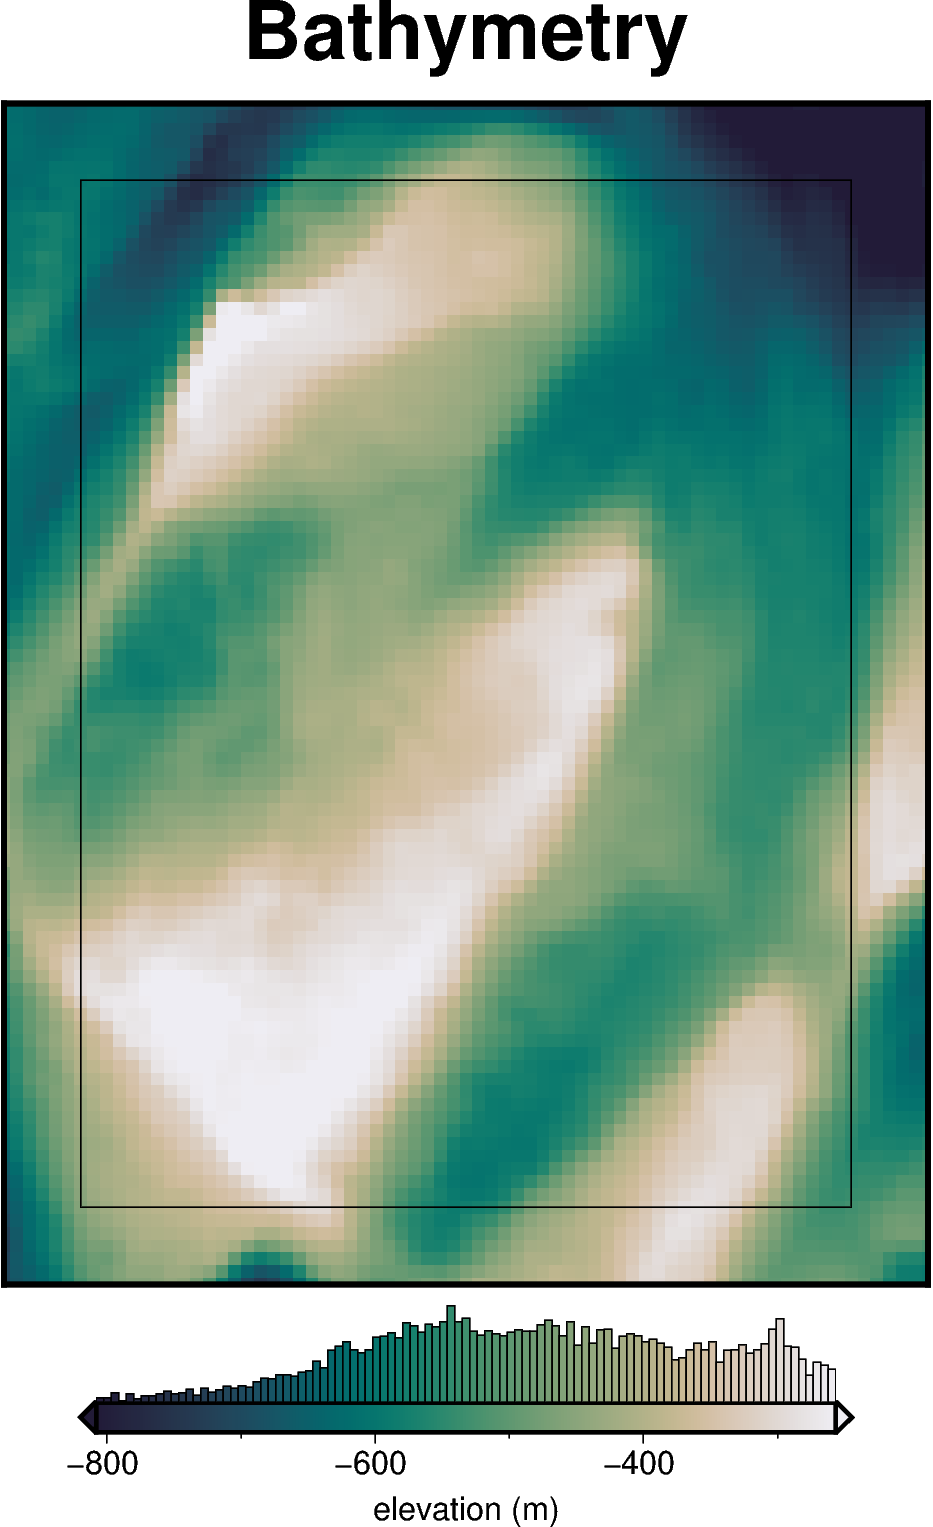

  0%|          | 0/4941 [00:00<?, ?it/s]

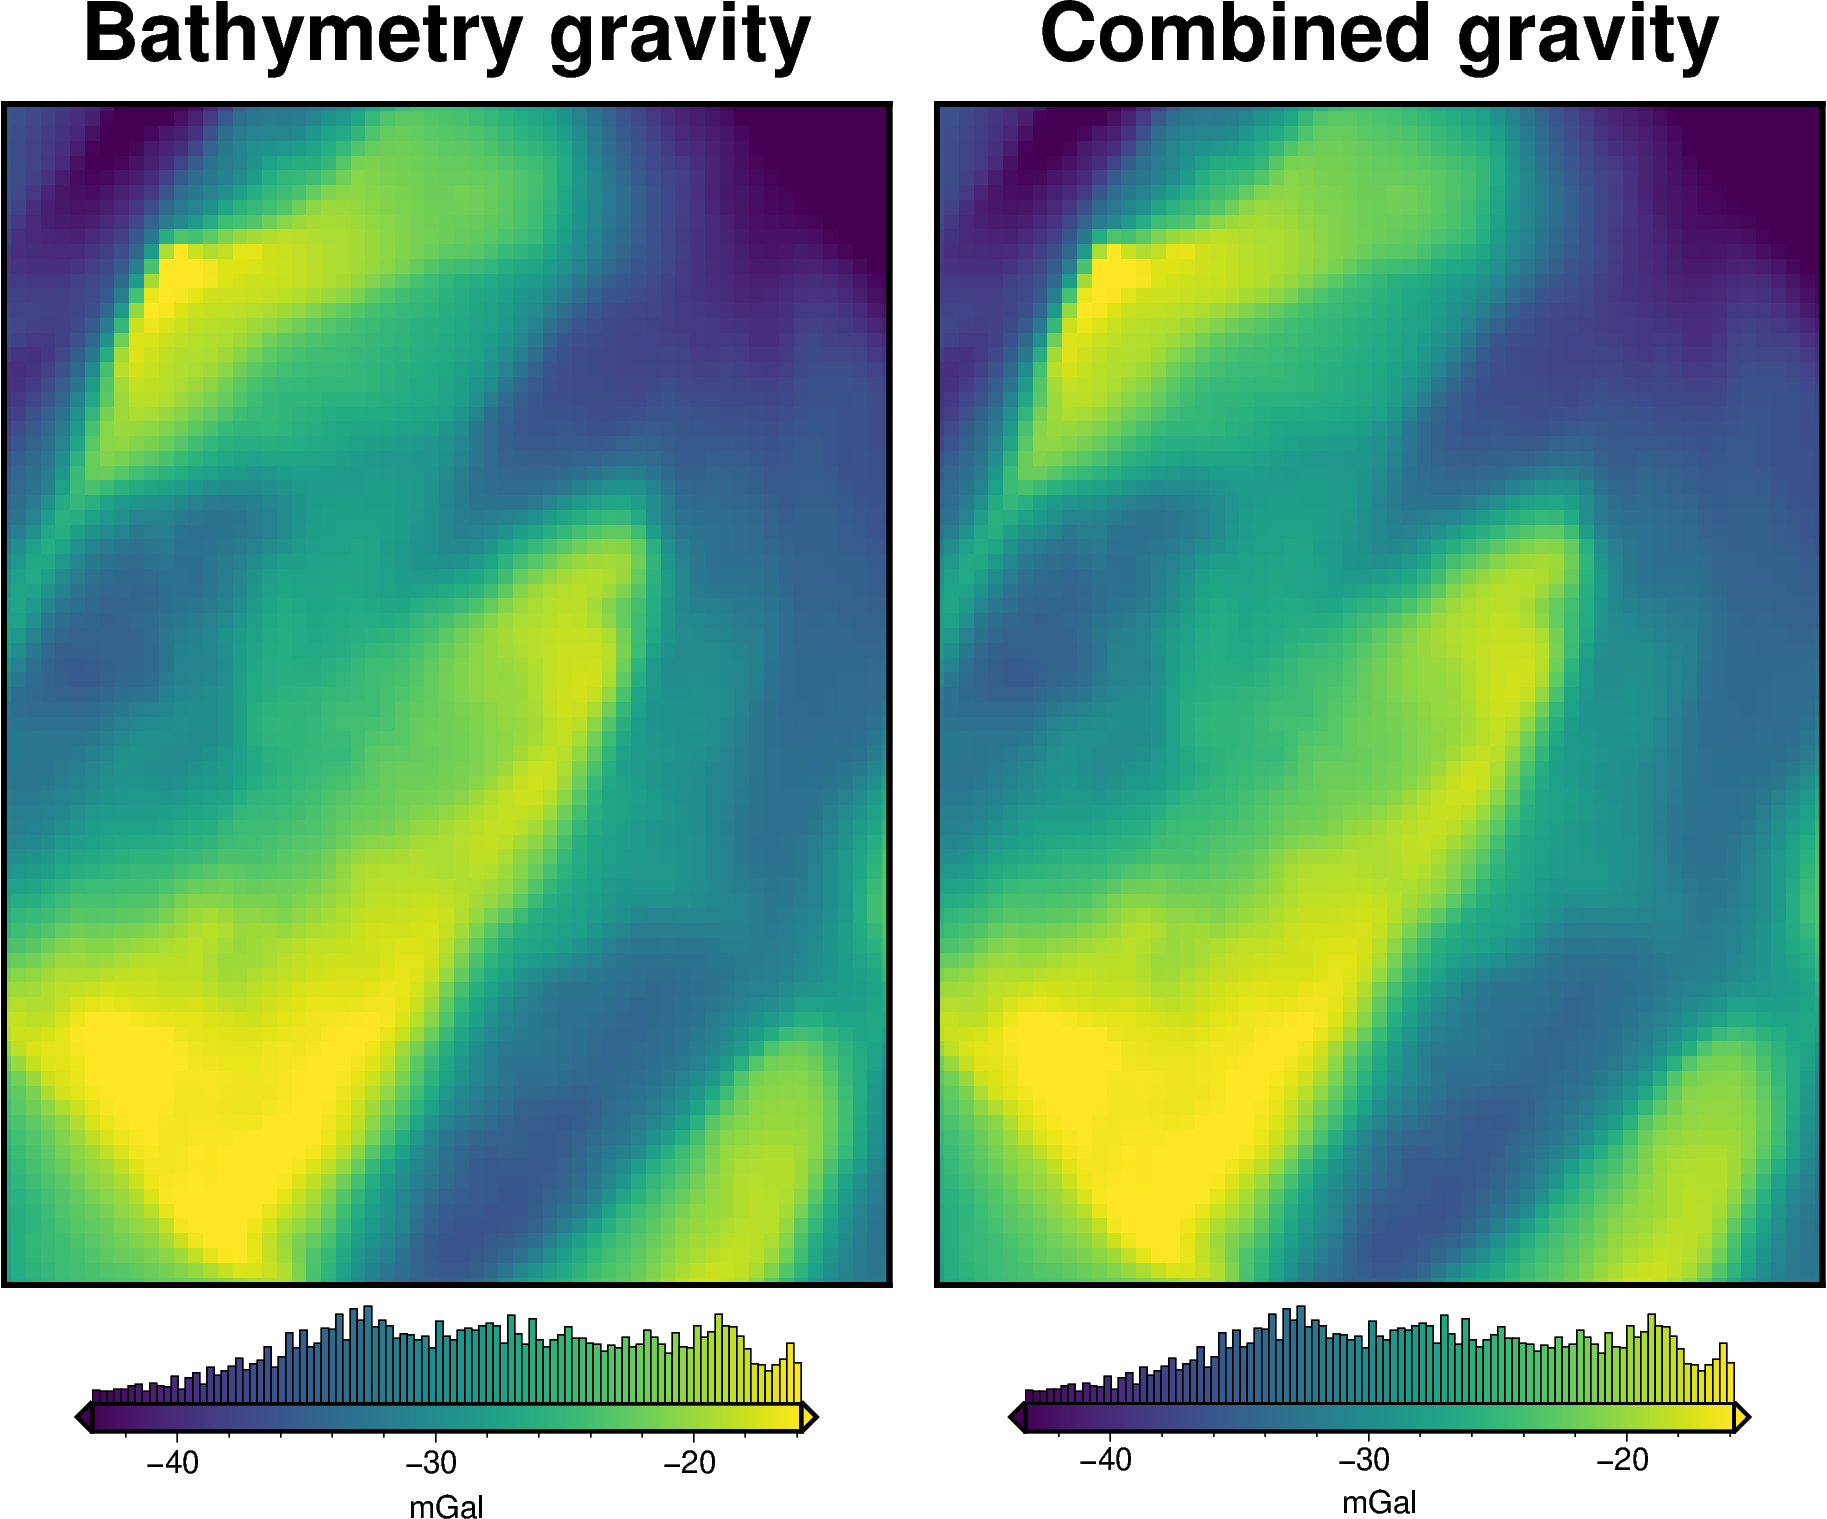

In [ ]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    gravity_noise=0,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

# rename the full res gravity column
grav_df=grav_df.rename(columns={"gravity_anomaly": "gravity_anomaly_full_res_no_noise"})

In [4]:
grav_df.describe()

northing       easting  upward  bathymetry_grav  basement_grav  \
count  4.941000e+03    4941.00000  4941.0      4941.000000         4941.0   
mean  -1.600000e+06  110000.00000  1000.0       -28.076339            0.0   
std    1.169164e+05   88042.99419     0.0         7.267542            0.0   
min   -1.800000e+06  -40000.00000  1000.0       -50.834525            0.0   
25%   -1.700000e+06   35000.00000  1000.0       -33.380910            0.0   
50%   -1.600000e+06  110000.00000  1000.0       -28.037682            0.0   
75%   -1.500000e+06  185000.00000  1000.0       -21.983838            0.0   
max   -1.400000e+06  260000.00000  1000.0       -13.088736            0.0   

       disturbance  uncert  gravity_anomaly_full_res_no_noise  
count  4941.000000  4941.0                        4941.000000  
mean    -28.076339     0.0                         -28.076339  
std       7.267542     0.0                           7.267542  
min     -50.834525     0.0                         -50.834525  
25%     -33.380910     0.0                         -33.380910  
50%     -28.037682     0.0                         -28.037682  
75%     -21.983838     0.0                         -21.983838  
max     -13.088736     0.0                         -13.088736

# Make starting bathymetry model

In [5]:
# make a flat starting model at the mean elevation of the true bathymetry
starting_bathymetry = utils.create_topography(
    method="flat",
    upwards=bathymetry.values.mean(),
    region=buffer_region,
    spacing=spacing,
)
starting_bathymetry

<xarray.DataArray 'upward' (northing: 93, easting: 73)> Size: 54kB
array([[-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       ...,
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631]])
Coordinates:
  * easting   (easting) float64 584B -7e+04 -6.5e+04 -6e+04 ... 2.85e+05 2.9e+05
  * northing  (northing) float64 744B -1.83e+06 -1.825e+06 ... -1.37e+06

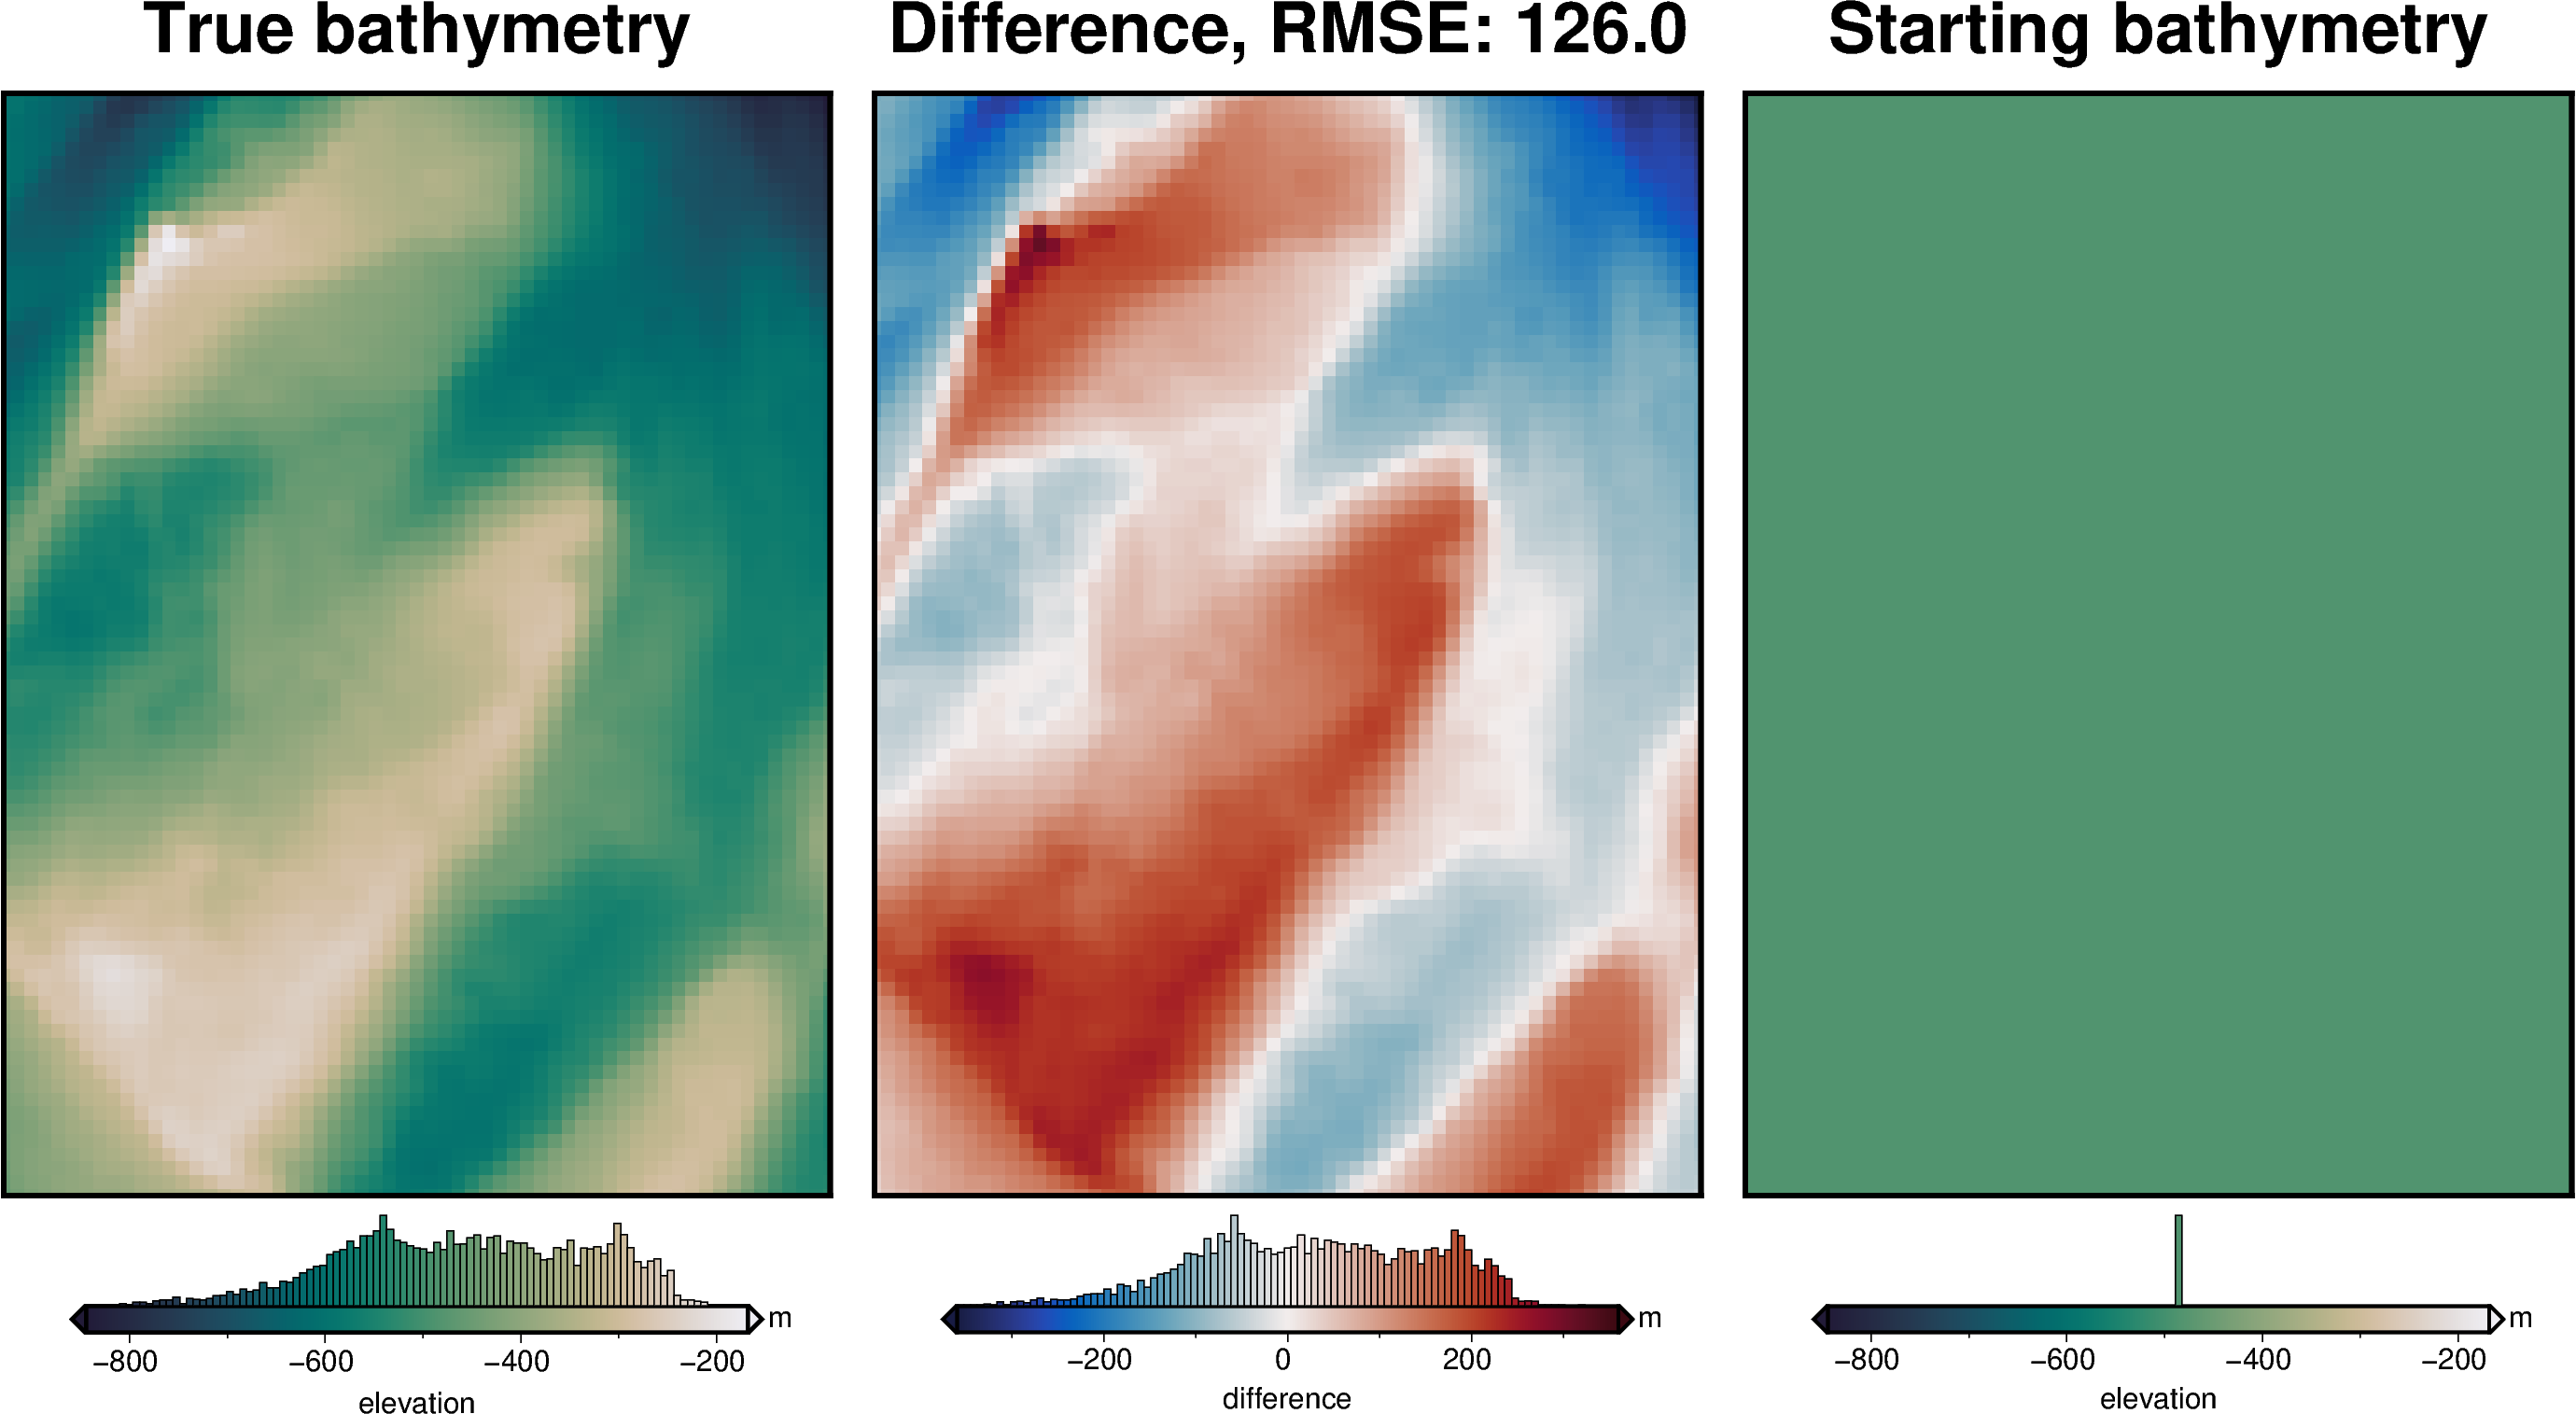

In [6]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
)

In [7]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1800000.0  -40000.0  1000.0       -28.046289              0   
1    -1800000.0  -35000.0  1000.0       -26.714502              0   
2    -1800000.0  -30000.0  1000.0       -25.919276              0   
3    -1800000.0  -25000.0  1000.0       -25.236960              0   
4    -1800000.0  -20000.0  1000.0       -24.610928              0   
...         ...       ...     ...              ...            ...   
4936 -1400000.0  240000.0  1000.0       -48.323584              0   
4937 -1400000.0  245000.0  1000.0       -48.356131              0   
4938 -1400000.0  250000.0  1000.0       -49.079005              0   
4939 -1400000.0  255000.0  1000.0       -49.877171              0   
4940 -1400000.0  260000.0  1000.0       -50.834525              0   

      disturbance  uncert  gravity_anomaly_full_res_no_noise  starting_gravity  
0      -28.046289     0.0                         -28.046289        -29.341524  
1      -26.714502     0.0                         -26.714502        -29.382051  
2      -25.919276     0.0                         -25.919276        -29.412038  
3      -25.236960     0.0                         -25.236960        -29.434973  
4      -24.610928     0.0                         -24.610928        -29.452985  
...           ...     ...                                ...               ...  
4936   -48.323584     0.0                         -48.323584        -29.452985  
4937   -48.356131     0.0                         -48.356131        -29.434973  
4938   -49.079005     0.0                         -49.079005        -29.412038  
4939   -49.877171     0.0                         -49.877171        -29.382051  
4940   -50.834525     0.0                         -50.834525        -29.341524  

[4941 rows x 9 columns]

# Run ensemble of inversions with varying survey line spacing and noise

In [39]:
# Define number of flights lines on log scale
line_numbers = np.unique(np.round(np.geomspace(1,40,10)))
# line_numbers = np.linspace(1, 40, 10).astype(int)

line_numbers = [int(i) for i in line_numbers]
line_numbers.reverse()
# line_numbers = [line_numbers[0], line_numbers[-1]]
line_numbers

[40, 27, 18, 12, 8, 5, 3, 2, 1]

In [38]:
noise_levels = [float(round(x,2)) for x in np.linspace(0, 6, 9)]
# noise_levels = [noise_levels[0], noise_levels[-1]]
noise_levels

[0.0, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0]

In [40]:
param_coords = []
line_spacings = []
grav_survey_dfs = []
for i, (n, s) in enumerate((product(noise_levels, line_numbers, desc="Noise/Spacing"))):
    param_coords.append([n, s])

    grav_survey_df = RIS_synth.airborne_survey(
        along_line_spacing=1e3,
        grav_observation_height=1e3,
        NS_line_number=s,
        EW_line_number=s,
        region=inversion_region,
        grav_grid=grav_df.set_index(['northing', 'easting']).gravity_anomaly_full_res_no_noise.to_xarray(),
        plot=False,
    )
    grav_survey_dfs.append(grav_survey_df)
    x_spacing=(inversion_region[1]-inversion_region[0])/s
    y_spacing=(inversion_region[3]-inversion_region[2])/s

    line_spacing = round((x_spacing + y_spacing)/2, -3)
    line_spacings.append(line_spacing)

Noise/Spacing:   0%|          | 0/81 [00:00<?, ?it/s]

In [41]:
grav_dfs = []
grav_grids = []
for i, (n, s) in enumerate(tqdm(param_coords)):

    grav_survey_df = grav_survey_dfs[i]
    # grid the airborne survey data over the whole grid
    coords = (grav_survey_df.easting, grav_survey_df.northing, grav_survey_df.upward)
    data = grav_survey_df.gravity_anomaly

    study, eqs = optimization.optimize_eq_source_params(
        coords,
        data,
        n_trials=10,
        damping_limits=[1e-20, 1],
        depth_limits=[10e3, 200e3],
        block_size=spacing*5,
        # plot=True,
        progressbar=False,
    )

    # copy gravity dataframe
    df = copy.deepcopy(grav_df)

    # predict sources onto grid
    df["gravity_anomaly"] = eqs.predict(
        (
            df.easting,
            df.northing,
            df.upward,  # either grav_df.upward or user-set constant value
        ),
    )

    # contaminated with long-wavelength noise
    contaminated = synthetic.contaminate_with_long_wavelength_noise(
        df.set_index(["northing", "easting"]).to_xarray().gravity_anomaly,
        coarsen_factor=None,
        spacing=50e3,
        noise_as_percent=False,
        noise=n,
    )
    contaminated_df = vd.grid_to_table(contaminated.rename("gravity_anomaly")).reset_index(drop=True)

    df = pd.merge(df.drop(columns=["gravity_anomaly"], errors="ignore"), contaminated_df, on=["easting", "northing"])

    # contaminate gravity with random noise
    df["gravity_anomaly"], stddev = synthetic.contaminate(
        df.gravity_anomaly,
        stddev=n,
        percent=False,
        seed=0
    )

    df = regional.regional_separation(
        grav_df=df,
        method="constant",
        constant=0,
    )

    grav_dfs.append(df)

    grav_grid = df.set_index(["northing", "easting"]).to_xarray()
    grav_grids.append(grav_grid)

  0%|          | 0/81 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'damping': 1.8220093796792354e-12}
INFO:invert4geom:	scores: [0.991469454373798]
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'damping': 1.8220093796792354e-12}
INFO:invert4geom:	scores: [0.9913800084344642]
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'damping': 1.8220093796792354e-12}
INFO:invert4geom:	scores: [0.9913781077745074]
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 9
INFO:invert4geom:	parameter: {'depth': 55357.550999746956, 'damping': 1.3735781186963916e-15}
INFO:invert4geom:	scores: [0.9931882010438455]
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'dampin

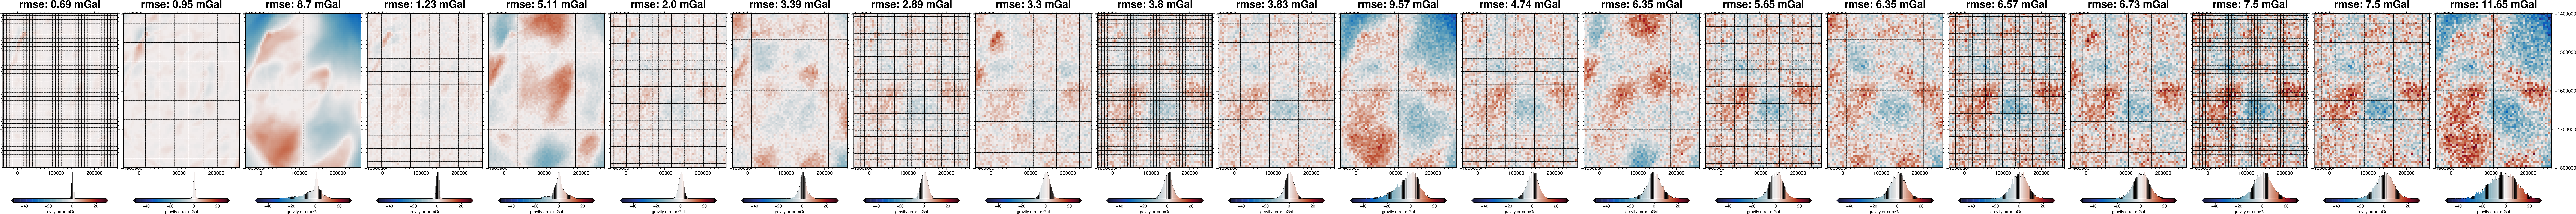

In [42]:
cpt_lims = polar_utils.get_min_max(grav_grid.gravity_anomaly_full_res_no_noise - grav_grids[-1].gravity_anomaly)

rmses = []
for i, g in enumerate(grav_grids):
    if i == 0:
        fig = None
        origin_shift="initialize"
    else:
        origin_shift="xshift"

    if i % 4 == 0:
        dif = (g.gravity_anomaly_full_res_no_noise - g.gravity_anomaly)
        fig = maps.plot_grd(
            # g.res,
            dif,
            region=inversion_region,
            fig_height=10,
            fig=fig,
            origin_shift=origin_shift,
            title=f"rmse: {round(utils.rmse(dif),2)} mGal",
            cmap="balance+h0",
            cpt_lims=cpt_lims,
            hist=True,
            cbar_label="gravity error mGal",
            frame=["nSwE", "xaf10000", "yaf10000"],
            points=grav_survey_dfs[i][["easting", "northing"]],
            points_style="p.02c",
        )
    rmses.append(utils.rmse(dif))

fig.show()

<Axes: >

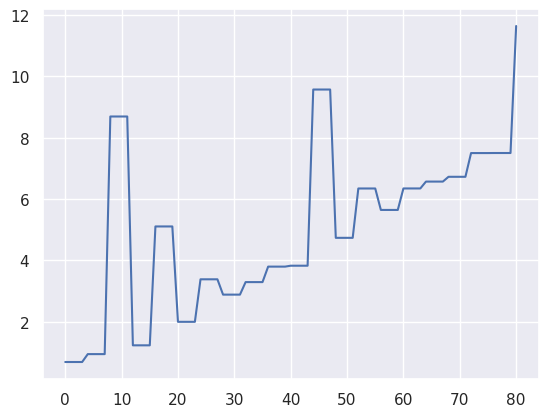

In [43]:
pd.Series(rmses).plot()

In [32]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "delta_l2_norm_tolerance": 1.008,
}

  0%|          | 0/81 [00:00<?, ?it/s]

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.020859053870359856}
INFO:invert4geom:	scores: [0.14761240183822433]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.020866477534652813}
INFO:invert4geom:	scores: [0.14719219156671842]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.0204914527267596}
INFO:invert4geom:	scores: [0.16655959717532595]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.020461559032453197}
INFO:invert4geom:	scores: [0.1685474676712753]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.020975510443108282}
INFO:invert4geom:	scores: [0.14148126423398086]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.020438768101819785}
INFO:invert4geom:	scores: [0.16826329267575646]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.021179737128694705}
INFO:invert4geom:	scores: [0.1343174772696661]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.02053878773586262}
INFO:invert4geom:	scores: [0.16210525275538673]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.022067676067389207}
INFO:invert4geom:	scores: [0.09551454321052245]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.0, 1]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.0253151153814825}
INFO:invert4geom:	scores: [0.190136169486817]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025315230010465834}
INFO:invert4geom:	scores: [0.19007002712915005]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025314468788408245}
INFO:invert4geom:	scores: [0.18983560478495498]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025317728366995116}
INFO:invert4geom:	scores: [0.18948787878800205]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02531899858129647}
INFO:invert4geom:	scores: [0.1898335670087023]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025299004195873907}
INFO:invert4geom:	scores: [0.18851051770752902]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02530418173255492}
INFO:invert4geom:	scores: [0.1911432150993379]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02535217746747654}
INFO:invert4geom:	scores: [0.18494889293392439]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025451626424001283}
INFO:invert4geom:	scores: [0.17903008853718927]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[0.75, 1]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025830767739814624}
INFO:invert4geom:	scores: [0.3149813002414603]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02583087969147742}
INFO:invert4geom:	scores: [0.314923533186749]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02583100061859452}
INFO:invert4geom:	scores: [0.31473073177555944]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025835265420747586}
INFO:invert4geom:	scores: [0.31444990440326265]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025838274008926614}
INFO:invert4geom:	scores: [0.31483022307675446]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025661392060344932}
INFO:invert4geom:	scores: [0.31322958543149]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02579729351997154}
INFO:invert4geom:	scores: [0.3151101117407498]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025613758257552223}
INFO:invert4geom:	scores: [0.310714179098853]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.025760489462415534}
INFO:invert4geom:	scores: [0.30577563601348606]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[1.5, 1]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026094379002846356}
INFO:invert4geom:	scores: [0.4649095501335515]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02609455926087819}
INFO:invert4geom:	scores: [0.4648606829527125]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026094558708046396}
INFO:invert4geom:	scores: [0.4647084418289921]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026101150385080818}
INFO:invert4geom:	scores: [0.46456231037338636]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026104587447090294}
INFO:invert4geom:	scores: [0.46490670802502326]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026066156502204597}
INFO:invert4geom:	scores: [0.46419532923214113]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02606942533222689}
INFO:invert4geom:	scores: [0.46496909014734256]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026043805889052564}
INFO:invert4geom:	scores: [0.46143228202372905]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026471972253484997}
INFO:invert4geom:	scores: [0.46305348679885705]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[2.25, 1]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026677826001617548}
INFO:invert4geom:	scores: [0.6373639992636454]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02667799996359241}
INFO:invert4geom:	scores: [0.6373188474194612]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026677801828774526}
INFO:invert4geom:	scores: [0.637178822171634]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026691197378163264}
INFO:invert4geom:	scores: [0.63736012471211]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026697208419745898}
INFO:invert4geom:	scores: [0.6378325499120486]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026618106399904525}
INFO:invert4geom:	scores: [0.6354343829557051]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026637326450415447}
INFO:invert4geom:	scores: [0.636694367324139]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02605362287075189}
INFO:invert4geom:	scores: [0.6109014073406156]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02624212600842381}
INFO:invert4geom:	scores: [0.605604610918498]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.0, 1]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026222807121478824}
INFO:invert4geom:	scores: [0.7717212888216922]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026222751234304675}
INFO:invert4geom:	scores: [0.7716689320523319]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026223603622507904}
INFO:invert4geom:	scores: [0.7716027115603855]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026223887482908315}
INFO:invert4geom:	scores: [0.7712699098442213]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026234024122358892}
INFO:invert4geom:	scores: [0.7719079242660766]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026220361490424622}
INFO:invert4geom:	scores: [0.7721861938810303]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026180877545094305}
INFO:invert4geom:	scores: [0.7711721808190233]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.0264529458910327}
INFO:invert4geom:	scores: [0.7812647979230736]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026682579784635722}
INFO:invert4geom:	scores: [0.7766501416681125]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[3.75, 1]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026471443213367234}
INFO:invert4geom:	scores: [0.9397501480706547]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026470876331957358}
INFO:invert4geom:	scores: [0.9396647225297675]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02647070592569722}
INFO:invert4geom:	scores: [0.9395567165532359]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026471232529814086}
INFO:invert4geom:	scores: [0.9391885218991117]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02648111998430763}
INFO:invert4geom:	scores: [0.9399071755340853]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026473066445189763}
INFO:invert4geom:	scores: [0.9407577072496742]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026391553200618267}
INFO:invert4geom:	scores: [0.9367132025628189]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026409687920335115}
INFO:invert4geom:	scores: [0.9336955068068499]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02704477106700798}
INFO:invert4geom:	scores: [0.9535551493884472]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[4.5, 1]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026203367127457373}
INFO:invert4geom:	scores: [1.0760184745869124]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026203302048342324}
INFO:invert4geom:	scores: [1.0759639983429516]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.0262035139283344}
INFO:invert4geom:	scores: [1.075896257793737]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02620046398213337}
INFO:invert4geom:	scores: [1.0752472106072768]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02621454738839565}
INFO:invert4geom:	scores: [1.0763198512437415]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026209714877591144}
INFO:invert4geom:	scores: [1.0775260736637917]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026518389733903573}
INFO:invert4geom:	scores: [1.101278099983381]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02662488411372554}
INFO:invert4geom:	scores: [1.1045799857028211]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02781115010815737}
INFO:invert4geom:	scores: [1.16866768369064]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[5.25, 1]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 40]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.02627292314462037}
INFO:invert4geom:	scores: [1.234852480252779]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 40]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 27]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026271722519535527}
INFO:invert4geom:	scores: [1.2347008869988347]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 27]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 18]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026273531971261872}
INFO:invert4geom:	scores: [1.2347760764652818]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 18]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 12]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026263568242374174}
INFO:invert4geom:	scores: [1.2334534337443581]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 12]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 8]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026261066775191844}
INFO:invert4geom:	scores: [1.233280598322411]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 8]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 5]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026343790830903473}
INFO:invert4geom:	scores: [1.2420871002248448]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 5]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 3]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.026118922221541465}
INFO:invert4geom:	scores: [1.2247402687888138]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 3]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 2]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.027742382786528158}
INFO:invert4geom:	scores: [1.358211178737142]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 2]_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 1]'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.01743105482065381}
INFO:invert4geom:	scores: [1.5068270728052755]
INFO:invert4geom:results saved to ../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_[6.0, 1]_results.pickle.pickle


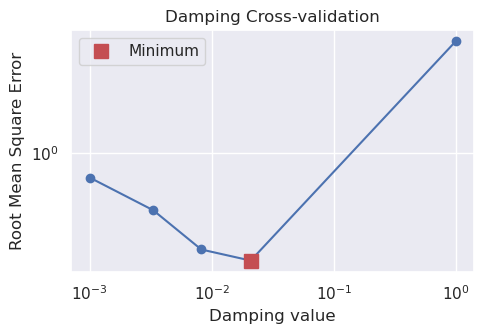

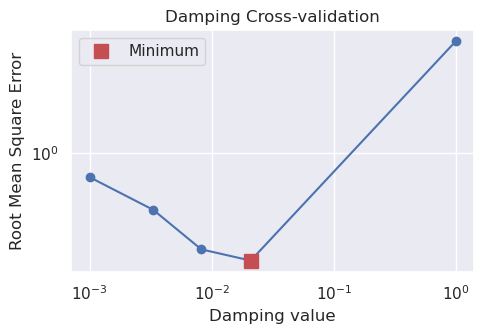

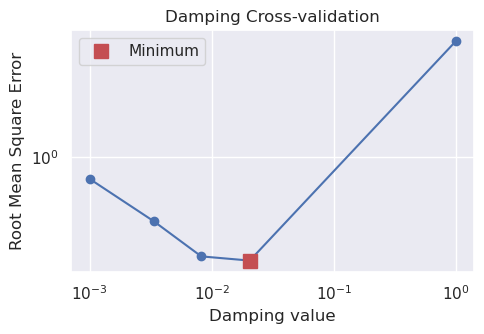

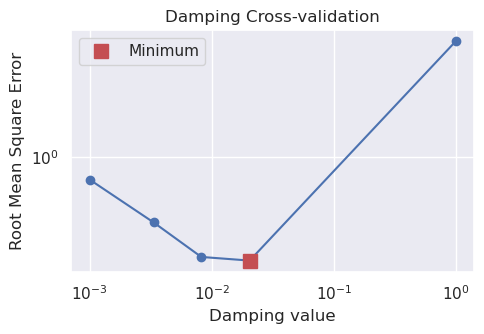

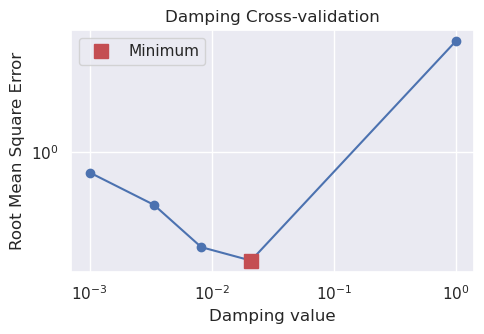

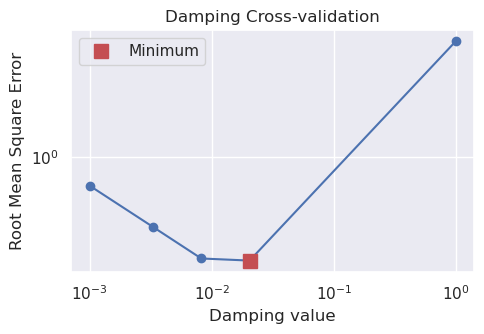

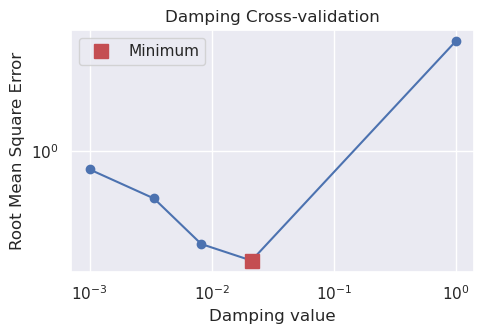

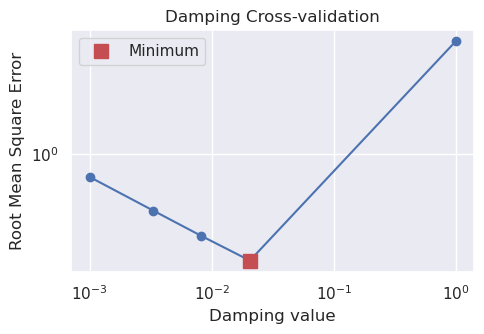

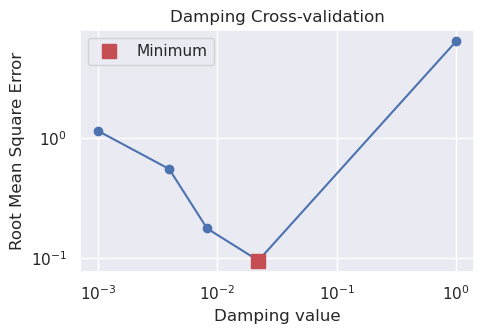

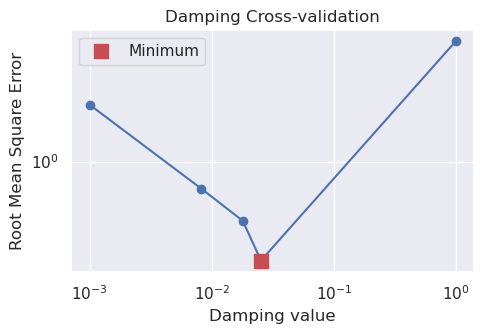

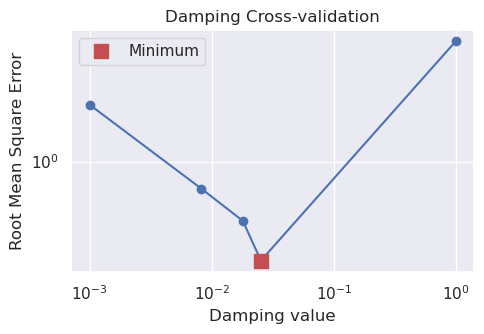

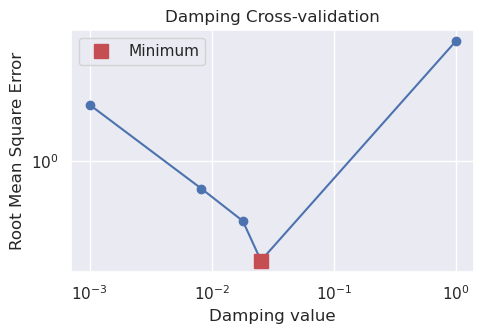

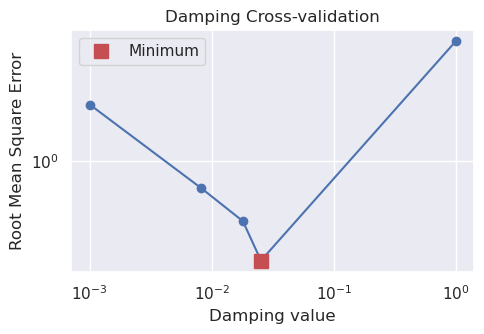

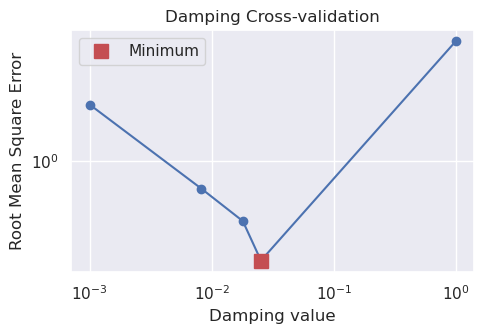

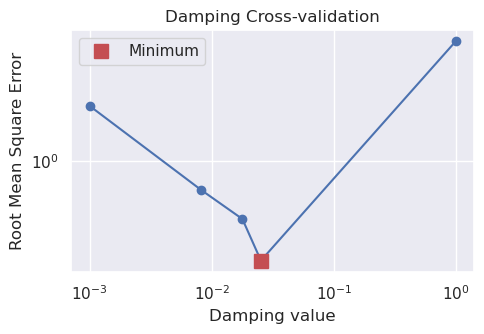

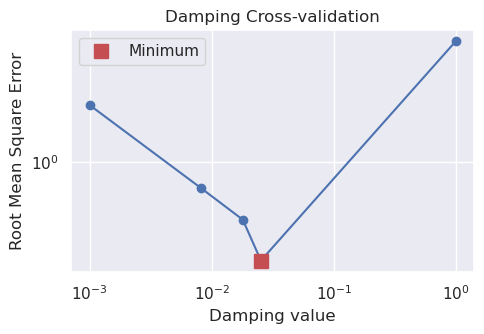

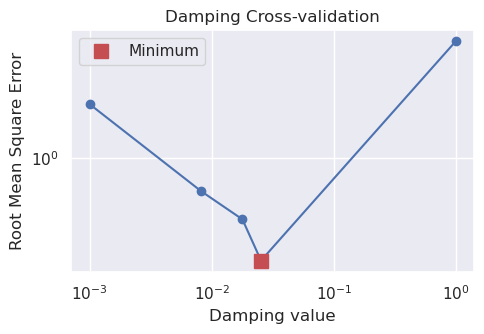

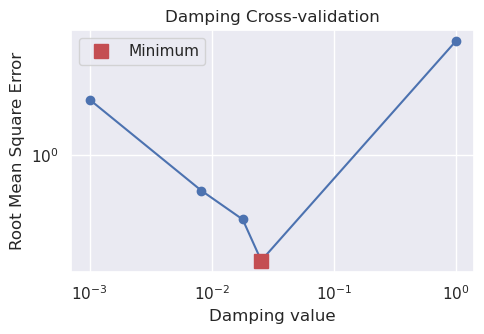

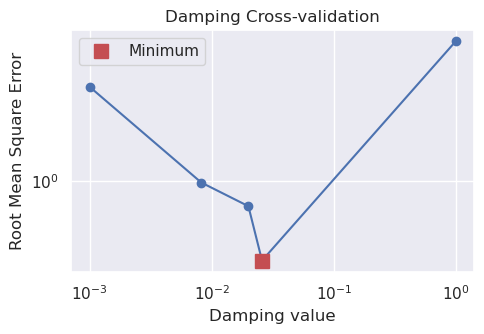

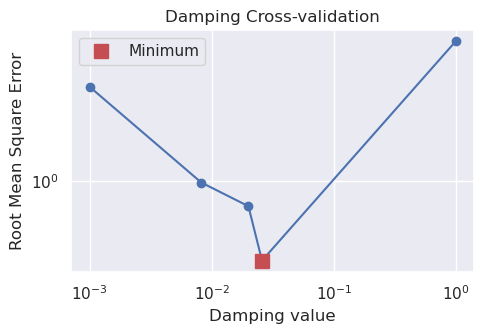

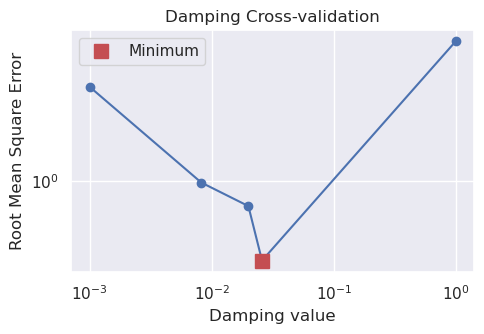

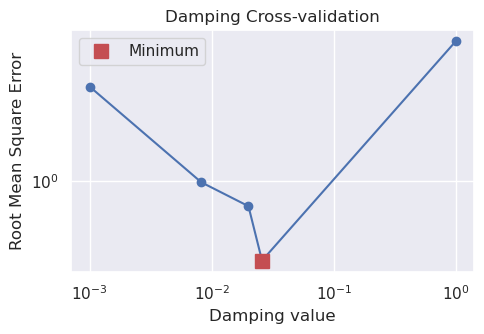

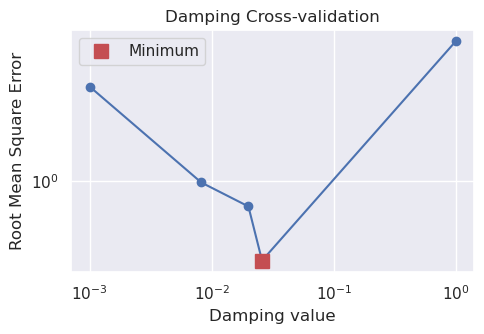

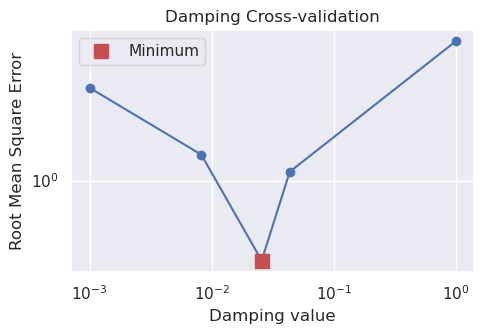

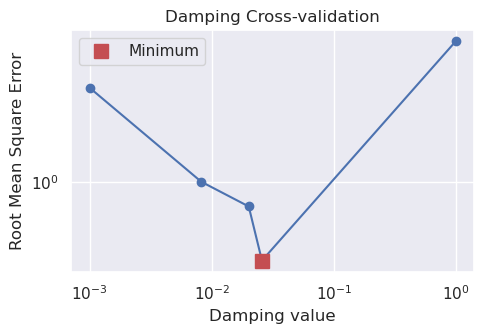

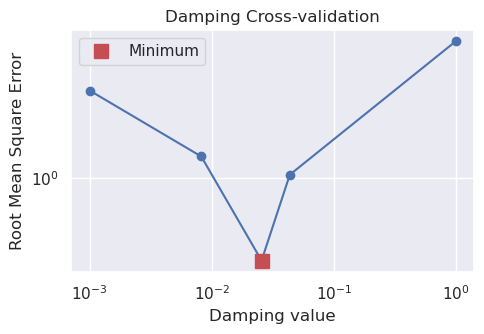

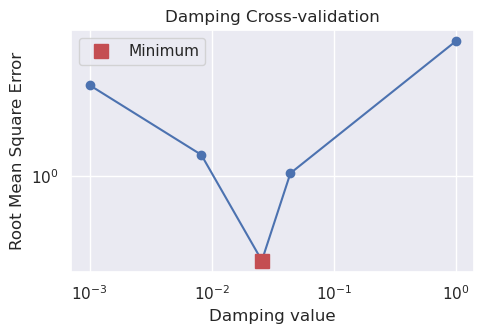

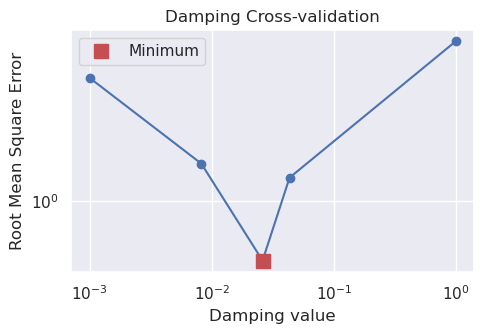

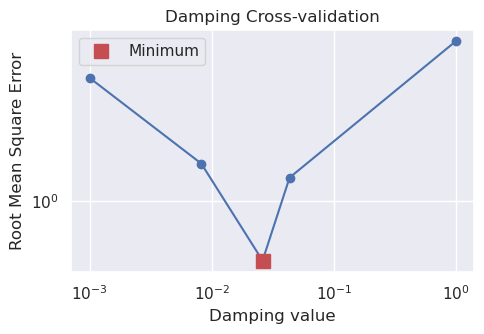

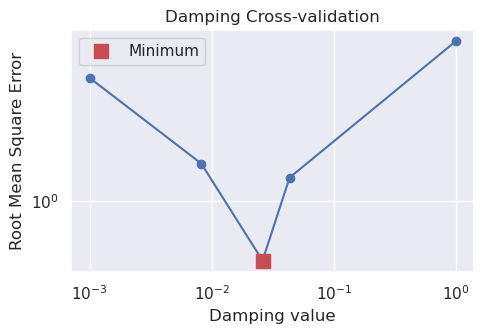

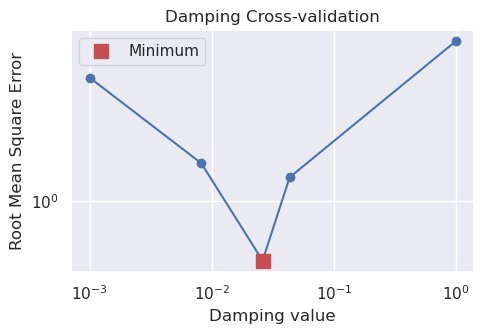

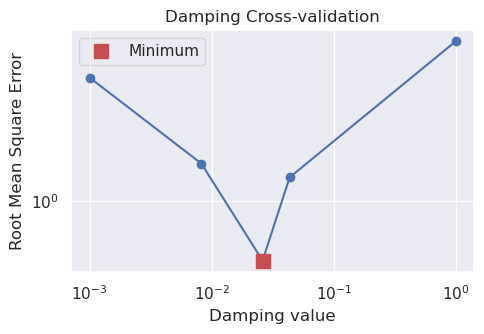

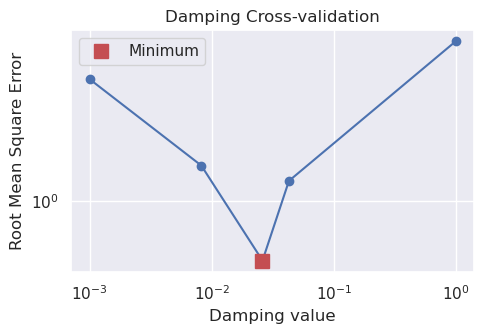

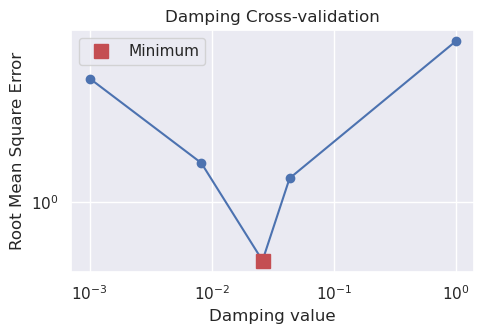

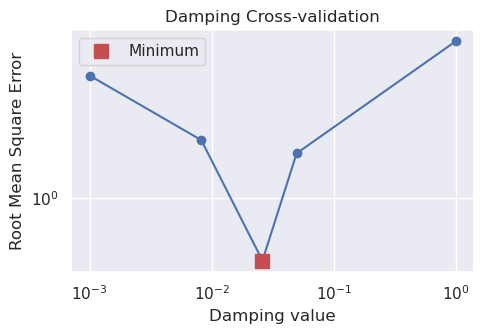

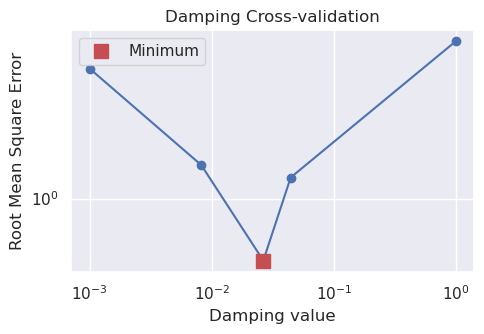

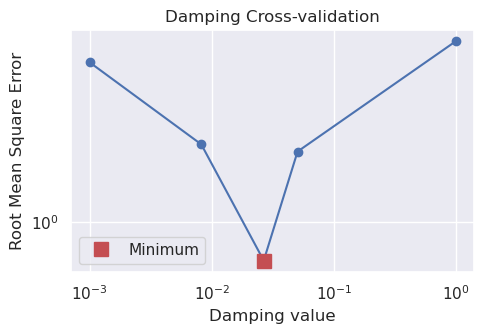

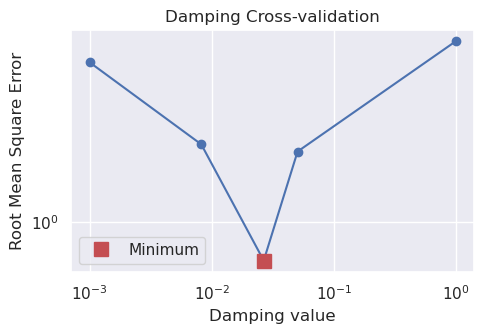

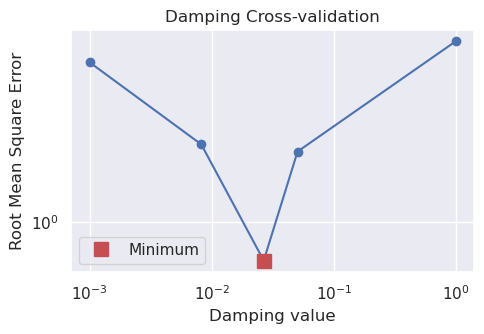

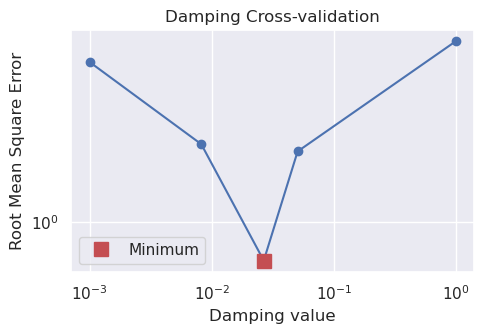

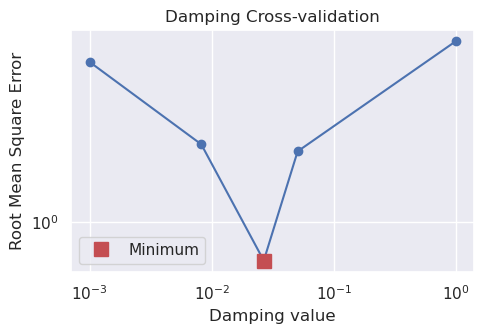

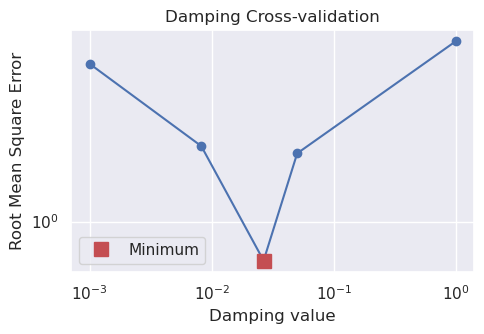

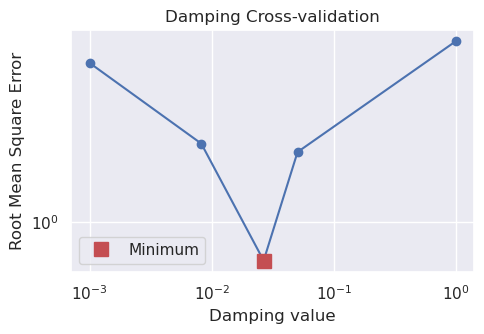

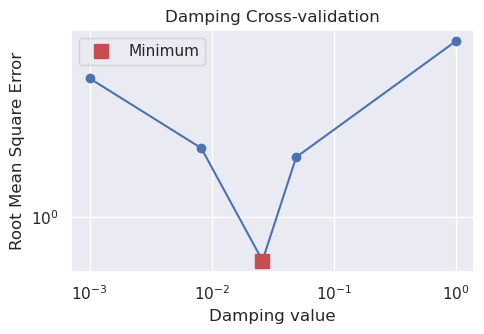

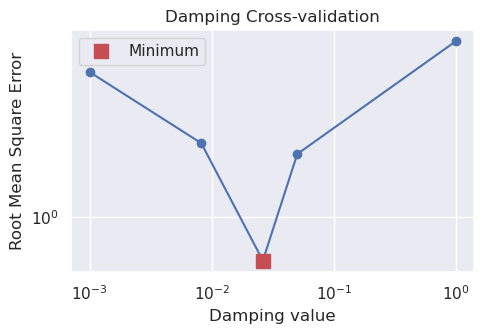

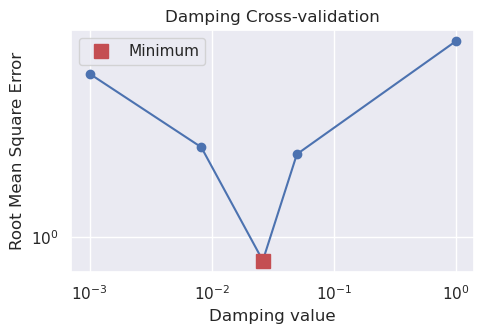

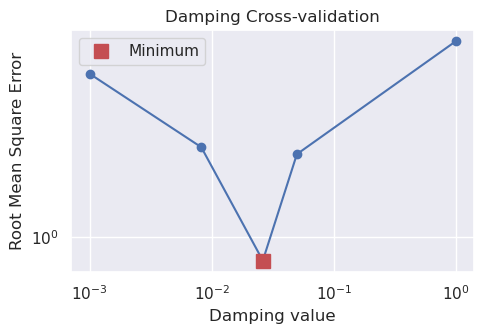

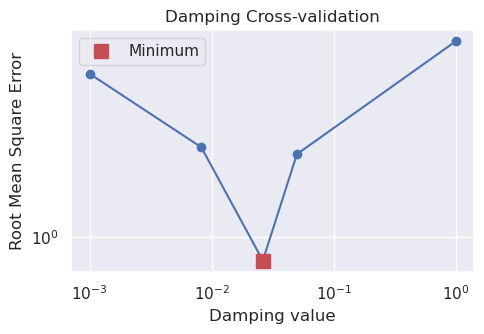

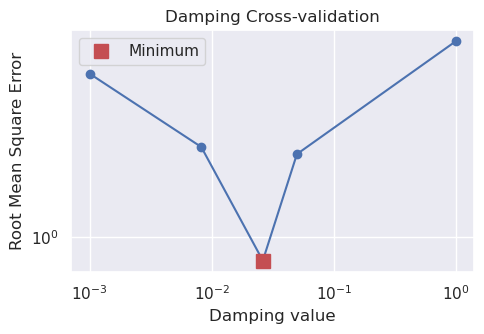

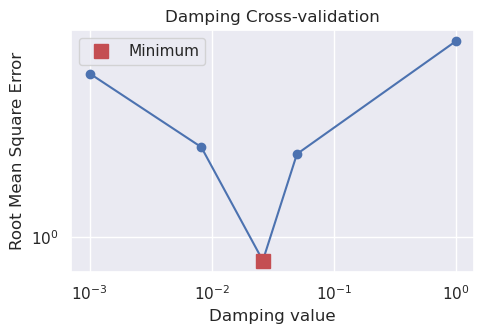

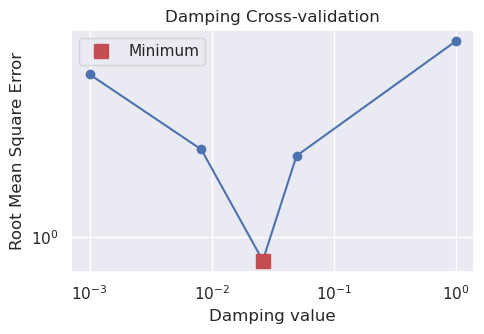

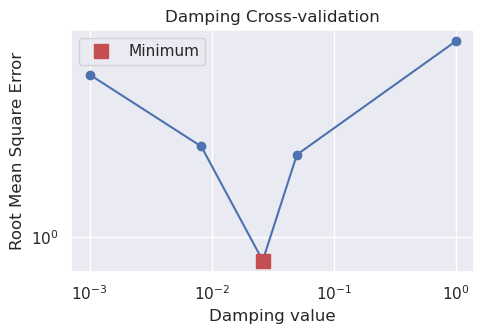

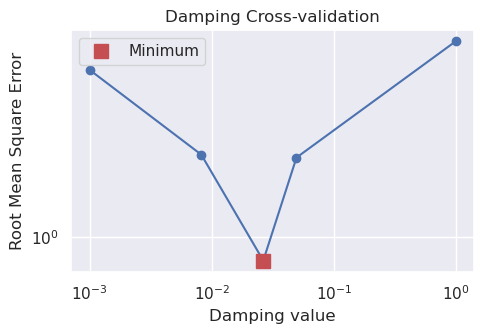

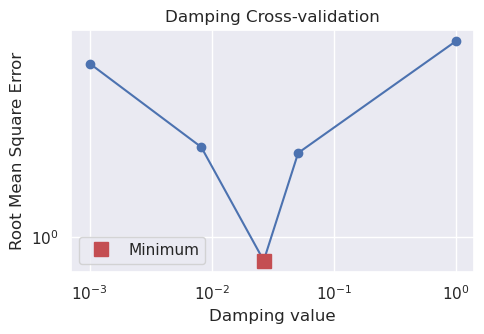

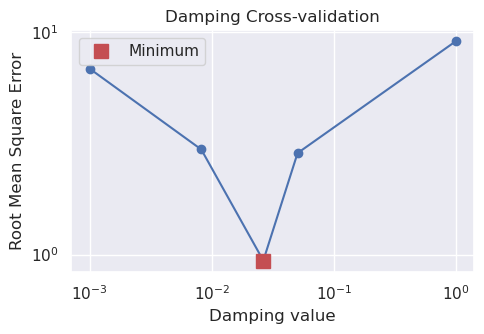

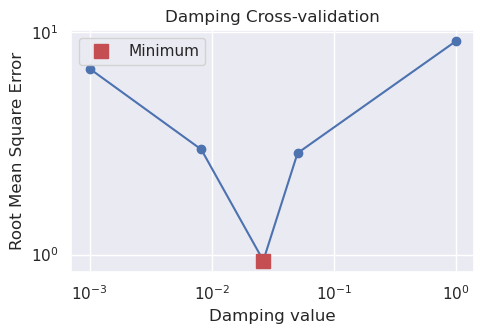

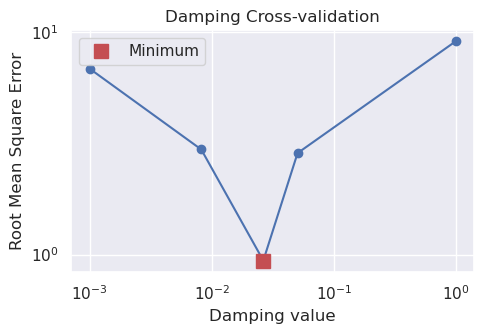

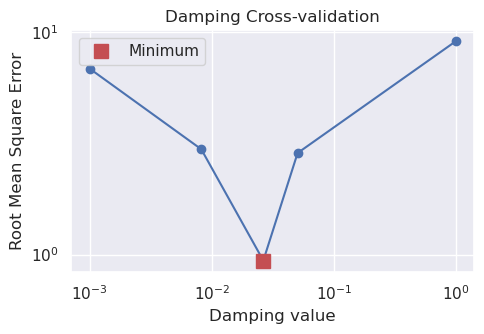

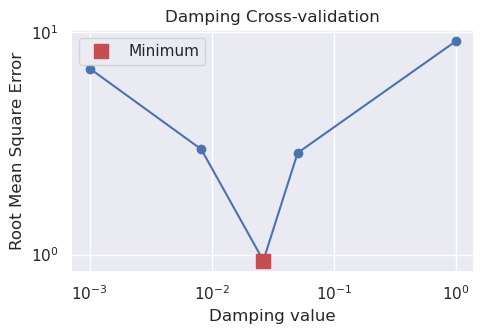

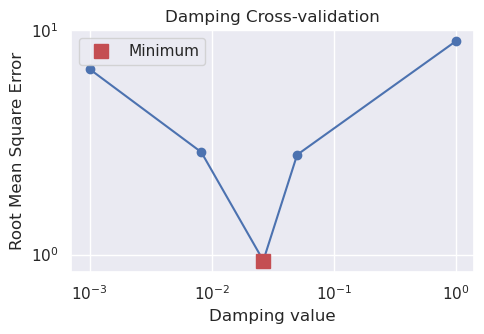

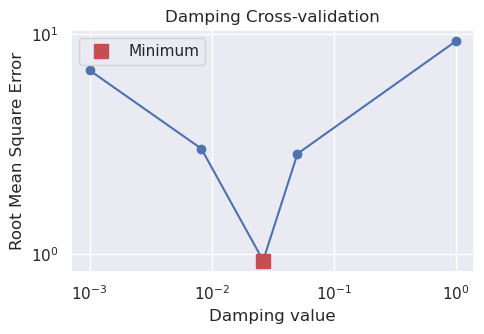

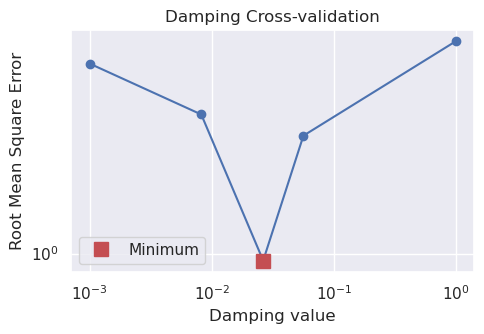

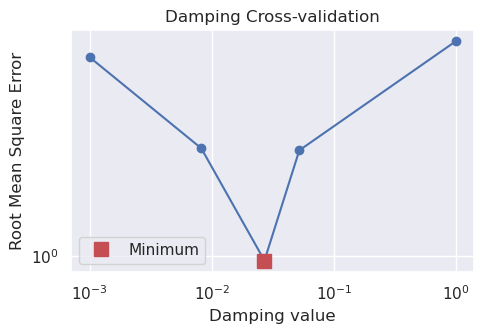

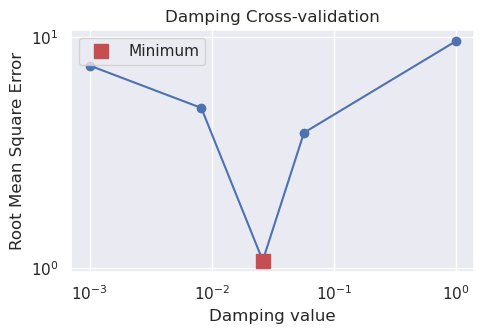

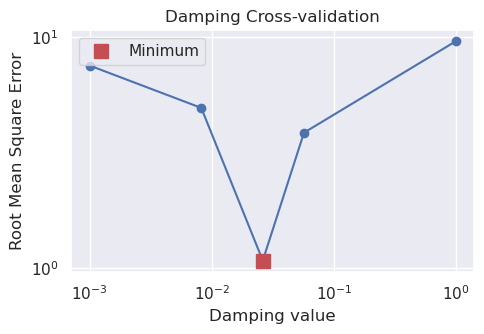

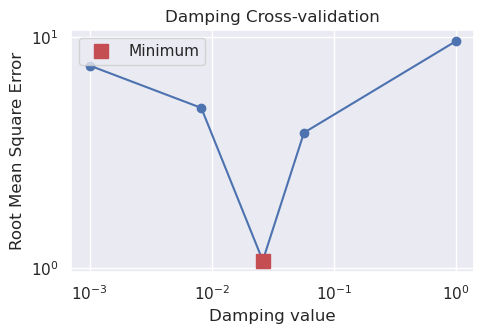

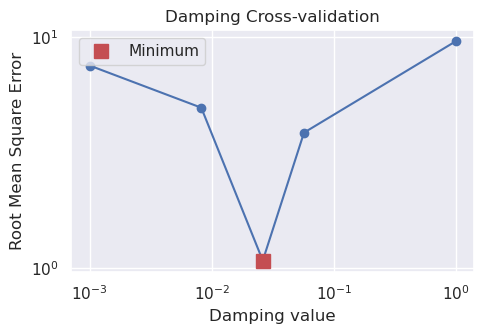

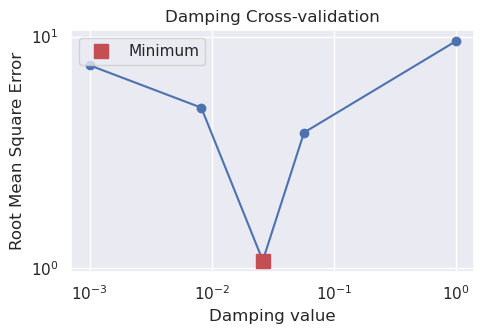

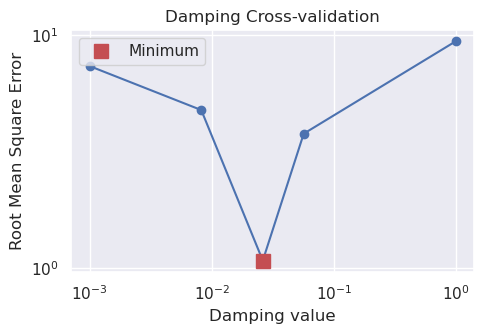

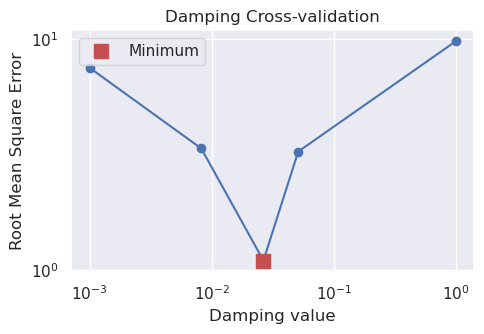

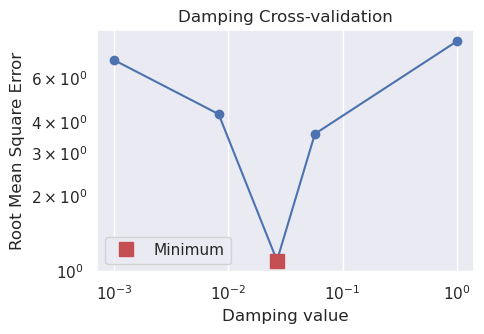

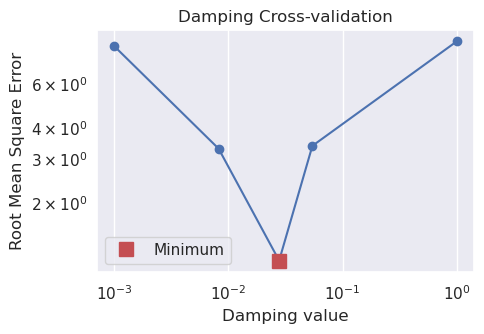

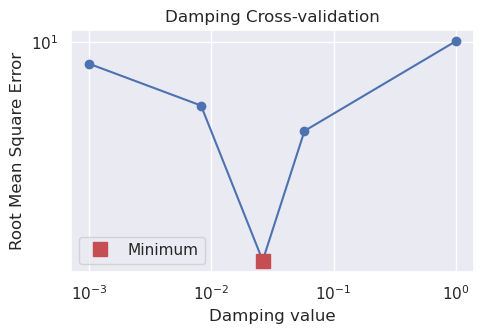

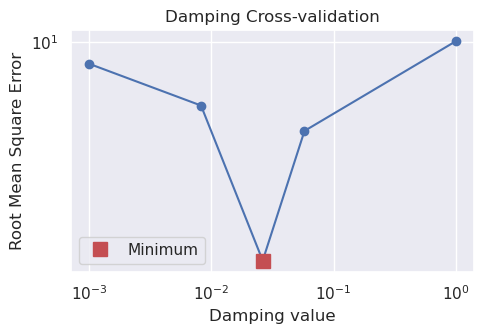

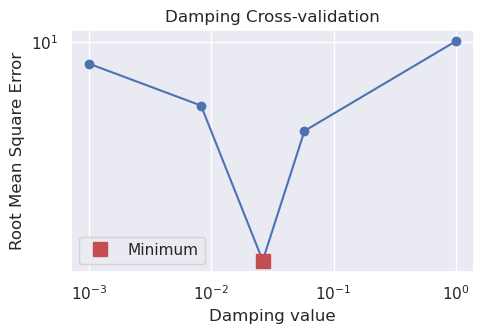

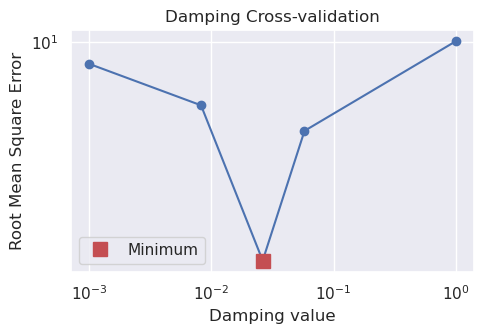

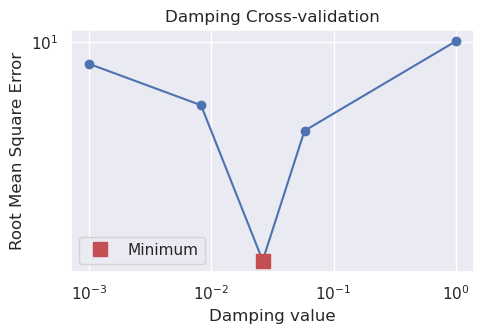

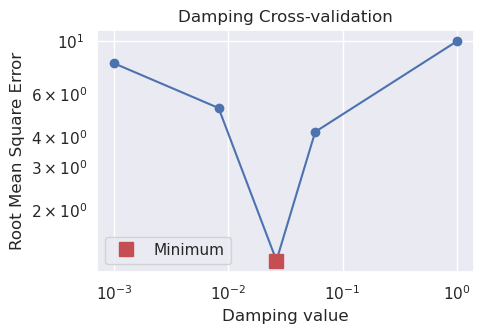

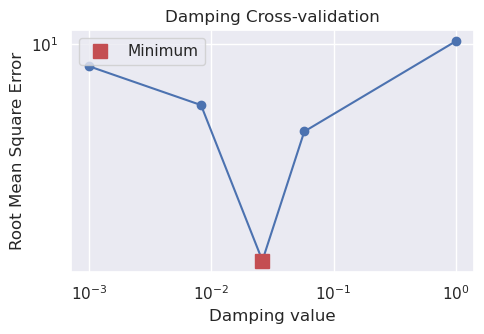

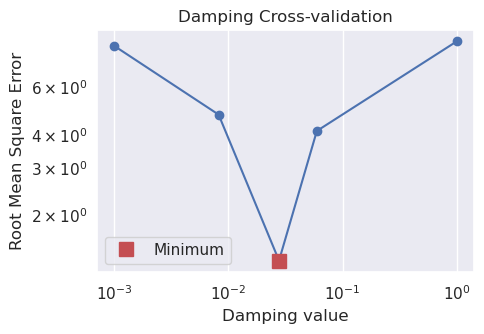

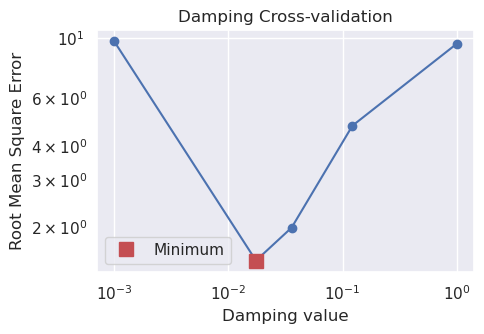

In [34]:
logging.getLogger().setLevel(logging.INFO)

for i, df in enumerate(tqdm(grav_dfs)):

    if param_coords[i][0] == 0:
        l2_norm_tolerance = .5
    else:
        l2_norm_tolerance=param_coords[i][0]**.5

    # run the inversion workflow, including a cross validation for the damping parameter
    results = inversion.run_inversion_workflow(
        grav_df=df,
        starting_prisms=starting_prisms,
        # for creating test/train splits
        grav_spacing=spacing,
        inversion_region=inversion_region,
        # solver_damping=0.02,
        run_damping_cv=True,
        damping_limits=(0.001, 1),
        damping_cv_trials=5,
        plot_cv=True,
        fname=f"../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_{param_coords[i]}",
        l2_norm_tolerance=l2_norm_tolerance,
        **kwargs,
    )

    # plotting.plot_inversion_results(
    #     results[1],
    #     results[0],
    #     results[2],
    #     inversion_region,
    #     iters_to_plot=4,
    #     plot_iter_results=True,
    #     plot_topo_results=False,
    #     plot_grav_results=True,
    # )


In [47]:
scores = []
rmses = []
dampings = []
param_coords = []
for n, s in product(noise_levels, line_numbers):
    param_coords.append([n, s])
for i, j in enumerate(param_coords):
    fname=f"../../results/Ross_Sea_09_damping_cv_gravity_spacing_noise_{j}"

    with pathlib.Path(f"{fname}_results.pickle").open("rb") as f:
        results = pickle.load(f)

    with pathlib.Path(f"{fname}_damping_cv_study.pickle").open("rb") as f:
        study = pickle.load(f)
    dampings.append(study.best_params["damping"])
    scores.append(study.best_value)

    final_topo = results[0].set_index(["northing", "easting"]).to_xarray().topo
    inside_final_topo = final_topo.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    inside_bathy = bathymetry.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    rmse = utils.rmse(inside_final_topo-inside_bathy)
    rmses.append(rmse)

    # if i % 10 == 0:
    #     plotting.plot_inversion_results(
    #         results[1],
    #         results[0],
    #         results[2],
    #         inversion_region,
    #         iters_to_plot=2,
    #         plot_iter_results=True,
    #         plot_topo_results=False,
    #         plot_grav_results=True,
    #     )
    #     _ = polar_utils.grd_compare(
    #         inside_bathy,
    #         inside_final_topo,
    #         plot=True,
    #         grid1_name="True topography",
    #         grid2_name="Inverted topography",
    #         robust=True,
    #         hist=True,
    #         inset=False,
    #         verbose="q",
    #         title="difference",
    #         grounding_line=False,
    #         reverse_cpt=True,
    #         cmap="rain",
    #     )

ensemble_df = pd.DataFrame(
    {
        "line_spacing_km": [l/1e3 for l in line_spacings],
        "line_numbers": [p[1] for p in param_coords],
        "noise": [p[0] for p in param_coords],
        "score": scores,
        "rmse": rmses,
        "dampings": dampings,
    }
)
ensemble_df

  0%|          | 0/81 [00:00<?, ?it/s]

line_spacing_km  line_numbers  noise     score        rmse  dampings
0               9.0            40    0.0  0.147612   16.158992  0.020859
1              13.0            27    0.0  0.147192   16.162747  0.020866
2              19.0            18    0.0  0.166560   16.270280  0.020491
3              29.0            12    0.0  0.168547   17.232226  0.020462
4              44.0             8    0.0  0.141481   20.134342  0.020976
..              ...           ...    ...       ...         ...       ...
76             44.0             8    6.0  1.233281  158.244124  0.026261
77             70.0             5    6.0  1.242087  160.099849  0.026344
78            117.0             3    6.0  1.224740  167.154237  0.026119
79            175.0             2    6.0  1.358211  164.817200  0.027742
80            350.0             1    6.0  1.506827  233.327888  0.017431

[81 rows x 6 columns]

In [48]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    region=inversion_region,
)
starting_rmse = utils.rmse(grids[0])
starting_rmse

np.float64(126.4227739508887)

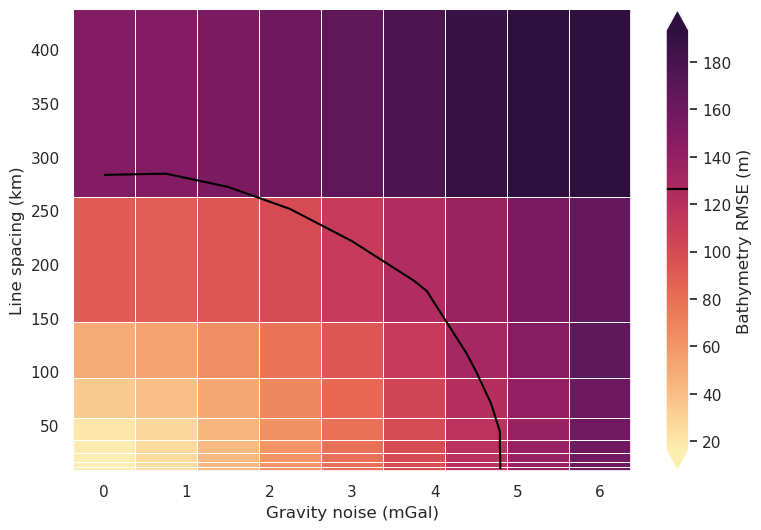

In [81]:
fig = RIS_plotting.plot_2var_ensemble(
    ensemble_df,
    x="noise",
    y="line_spacing_km",
    x_title="Gravity noise (mGal)",
    y_title="Line spacing (km)",
    background="rmse",
    background_title="Bathymetry RMSE (m)",
    background_robust=True,
    plot_contours=[starting_rmse],
)
# Results
# expected relationship between noise, line spacing and performance
# inversion only offers improvement for noise < 5mGal or line spacing < 300km

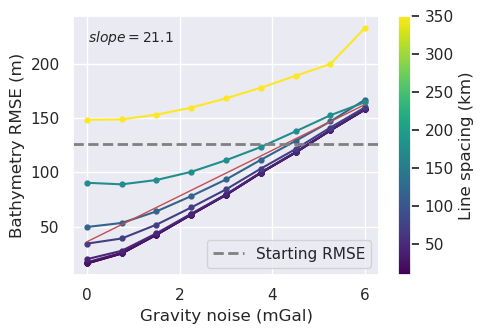

In [83]:
RIS_plotting.plot_ensemble_as_lines(
    ensemble_df,
    y="rmse",
    x="noise",
    groupby_col="line_spacing_km",
    x_label="Gravity noise (mGal)",
    cbar_label="Line spacing (km)",
    trend_line=True,
    horizontal_line=starting_rmse,
    horizontal_line_label="Starting RMSE",
)
# Results
# linear relationship between noise and performance for all line spacings
# noise more impactful for closer line spacings
# at high noise levels, lines spacing doesn't matter

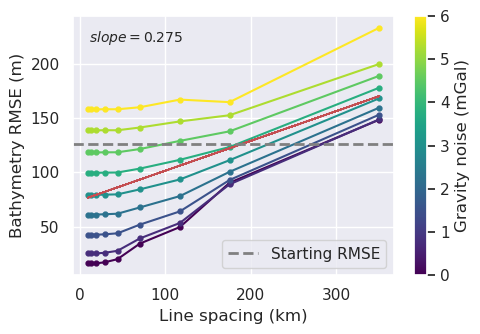

In [84]:
RIS_plotting.plot_ensemble_as_lines(
    ensemble_df,
    y="rmse",
    x="line_spacing_km",
    groupby_col="noise",
    x_label="Line spacing (km)",
    cbar_label="Gravity noise (mGal)",
    trend_line=True,
    horizontal_line=starting_rmse,
    horizontal_line_label="Starting RMSE",
)
# Results
# linear relationship between line spacing and performance for all noise levels
# even at low line spacings, noise still matters
# noise is slightly more important at smaller line spacings